In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import scipy as sp
import copy
from math import ceil
from shutil import which
from pyensembl import EnsemblRelease
from allel import GenotypeArray
from allel import read_vcf
from allel import rogers_huff_r_between
import matplotlib as mpl
from scipy import stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import MaxNLocator
import gc as garbage_collect
from adjustText import adjust_text
from gwaslab.viz_aux_reposition_text import adjust_text_position
from gwaslab.viz_aux_annotate_plot import annotate_single
from gwaslab.viz_plot_qqplot import _plot_qq
from gwaslab.hm_harmonize_sumstats import auto_check_vcf_chr_dict
from gwaslab.viz_plot_regional2 import _plot_regional
from gwaslab.viz_plot_regional2 import process_vcf
from gwaslab.viz_aux_quickfix import _get_largenumber
from gwaslab.viz_aux_quickfix import _quick_fix_p_value
from gwaslab.viz_aux_quickfix import _quick_fix_pos
from gwaslab.viz_aux_quickfix import _quick_fix_chr
from gwaslab.viz_aux_quickfix import _quick_fix_eaf
from gwaslab.viz_aux_quickfix import _quick_fix_mlog10p
from gwaslab.viz_aux_quickfix import _quick_add_tchrpos
from gwaslab.viz_aux_quickfix import _quick_merge_sumstats
from gwaslab.viz_aux_quickfix import _quick_assign_i
from gwaslab.viz_aux_quickfix import _quick_assign_i_with_rank
from gwaslab.viz_aux_quickfix import _quick_extract_snp_in_region
from gwaslab.viz_aux_quickfix import _quick_assign_highlight_hue_pair
from gwaslab.viz_aux_quickfix import _quick_assign_marker_relative_size
from gwaslab.viz_aux_quickfix import _cut
from gwaslab.viz_aux_quickfix import _set_yticklabels
from gwaslab.viz_aux_quickfix import _jagged_y
from gwaslab.viz_aux_save_figure import save_figure
from gwaslab.g_Log import Log
from gwaslab.util_in_calculate_gc import lambdaGC
from gwaslab.util_in_get_sig import getsig
from gwaslab.util_in_get_sig import annogene
from gwaslab.bd_common_data import get_chr_to_number
from gwaslab.bd_common_data import get_number_to_chr
from gwaslab.bd_common_data import get_recombination_rate
from gwaslab.bd_common_data import get_gtf
from gwaslab.g_version import _get_version
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_hex
# 20230202 ######################################################################################################

def mqqplot(insumstats,            
          chrom=None,
          pos=None,
          p=None,
          snpid=None,
          eaf=None,
          ea="EA",
          nea="NEA",
          check = True,
          chr_dict = None,
          xtick_chr_dict = None,
          vcf_path=None,
          vcf_chr_dict = None,
          gtf_path="default",
          gtf_chr_dict = None,
          gtf_gene_name=None,
          rr_path="default",
          rr_header_dict=None,
          rr_chr_dict = None,
          rr_lim=(0,100),
          rr_ylabel=True,
          mlog10p="MLOG10P",
          scaled=False,
          mode="mqq",
          scatter_args=None,
          scatterargs=None,
          qq_scatter_args=None,
          qqscatterargs=None,
          qq_line_color = "grey",
          # region
          region = None,
          region_title=None,
          region_title_args=None,
          region_ref=None,
          region_ref2=None,
          region_ref_second=None,
          region_step = 21,
          region_grid = False,
          region_grid_line = None,
          region_lead_grid = True,
          region_lead_grid_line = None,
          region_hspace=0.02,
          region_ld_threshold = None,
          region_ld_legend = True,
          region_ld_colors = None,
          region_ld_colors_m = None,
          region_recombination = True,
          region_protein_coding = True,
          region_flank_factor = 0.05,
          region_anno_bbox_args = None,
          region_marker_shapes=None,
          cbar_title='LD $r^{2}$ with variant',
          cbar_fontsize = None,
          cbar_font_family = None,
          track_n=4,
          track_n_offset=0,
          track_fontsize_ratio=0.95,
          track_exon_ratio=1,
          track_text_offset=1,
          track_font_family = None,
          taf = None,
          # track_n, track_n_offset,font_ratio,exon_ratio,text_offset
          tabix=None,
          mqqratio=3,
          bwindowsizekb = 100,
          density_color=False,
          density_range=(0,15),
          density_trange=(0,10),
          density_threshold=5,
          density_tpalette="Blues",
          density_palette="Reds",
          windowsizekb=500,
          anno=None,
          anno_set=None,
          anno_alias=None,
          anno_d=None,
          anno_args=None,
          anno_style="right",
          anno_fixed_arm_length=None,
          anno_source = "ensembl",
          anno_gtf_path=None,
          anno_adjust=False,
          anno_max_iter=100,
          arm_offset=50,
          arm_scale=1,
          anno_height=1,
          arm_scale_d=None,
          cut=0,
          skip=0,
          ystep=0,
          ylabels=None,
          ytick3=True,
          cutfactor=10,
          cut_line_color="#ebebeb",  
          cut_log = False,
          jagged=False,
          jagged_len=0.01,
          jagged_wid=0.01,
          sig_line=True,
          sig_level=None,
          sig_level_plot=5e-8,
          sig_level_lead=5e-8,
          sig_line_color="grey",
          suggestive_sig_line=False,
          suggestive_sig_level=5e-6,
          suggestive_sig_line_color="grey",
          additional_line = None,
          additional_line_color = None,
          sc_linewidth=2,
          highlight = None,
          highlight_chrpos = False,
          highlight_color="#CB132D",
          highlight_windowkb = 500,
          highlight_anno_args = None,
          pinpoint= None,
          pinpoint_color ="red",
          stratified=False,
          maf_bins=None,
          maf_bin_colors = None,
          gc=True,
          include_chrXYMT = True,
          ylim=None,
          xpad=None,
          xpadl=None,
          xpadr=None,
          xtight=False,
          chrpad=0.03, 
          drop_chr_start=False,
          title =None,
          mtitle=None,
          qtitle=None,
          ylabel=None,
          xlabel=None,
          title_pad=1.08, 
          title_fontsize=13,
          fontsize = 9,
          font_family="Arial",
          anno_fontsize = 9,
          figargs=None,
          fig_args= None,
          figax=None,
          colors=None,
          marker_size=(5,20),
          use_rank=False,
          verbose=True,
          repel_force=0.03,
          build=None,
          _posdiccul=None,
          dpi=200,
          save=None,
          save_args=None,
          saveargs=None,
          _invert=False,
          _chrom_df_for_i=None,
          _if_quick_qc=True,
          _get_region_lead=False,
          expected_min_mlog10p=0,
          log=Log()
          ):

# log.writeing meta info #######################################################################################
    if chr_dict is None:          
        chr_dict = get_chr_to_number()
    if xtick_chr_dict is None:         
        xtick_chr_dict = get_number_to_chr()
    if gtf_chr_dict is None:   
        gtf_chr_dict = get_number_to_chr()
    if rr_chr_dict is None:   
        rr_chr_dict = get_number_to_chr()
    if fig_args is None:
        fig_args= dict(figsize=(15,5))
    if figargs is not None:
        fig_args = figargs
    if "dpi" not in fig_args.keys():
        fig_args["dpi"] = dpi
    if region_anno_bbox_args is None:
        region_anno_bbox_args = dict()
    if anno_set is None:
        anno_set=list()
    if anno_alias is None:
        anno_alias=dict()
    if anno_d is None:
        anno_d=dict()
    if anno_args is None:
        anno_args=dict()
    if colors is None:
        colors=["#597FBD","#74BAD3"]
    
    if region is not None:
        if marker_size == (5,20):
            marker_size=(45,65)
    
    # make region_ref a list of ref variants
    if pd.api.types.is_list_like(region_ref):
        if len(region_ref) == 0 :
            region_ref.append(None)
            if region_ref_second is not None:
                region_ref.append(region_ref_second)
    else:
        region_ref = [region_ref]
        if region_ref_second is not None:
            region_ref.append(region_ref_second)
    region_ref_index_dic = {value: index for index,value in enumerate(region_ref)}
        
    if region_marker_shapes is None:
        # 9 shapes
        region_marker_shapes = ['o', 's','^','D','*','P','X','h','8']
    if region_grid_line is None:
        region_grid_line = {"linewidth": 2,"linestyle":"--"}
    if region_lead_grid_line is None:
        region_lead_grid_line = {"alpha":0.5,"linewidth" : 2,"linestyle":"--","color":"#FF0000"}
    if region_ld_threshold is None:
        region_ld_threshold = [0.2,0.4,0.6,0.8]

    if region_ld_colors is None:     
        region_ld_colors = ["#E4E4E4","#020080","#86CEF9","#24FF02","#FDA400","#FF0000","#FF0000"]
    
    # 7 colors    
    region_ld_colors_m = ["#E51819","#367EB7","green","#F07818","#AD5691","yellow","purple"]
    
    if region_title_args is None:
        region_title_args = {"size":10}
    if cbar_fontsize is None:
        cbar_fontsize = fontsize
    if cbar_font_family is None:
        cbar_font_family = font_family
    if track_font_family is None:
        track_font_family = font_family
    if taf is None:
        taf = [track_n,track_n_offset,track_fontsize_ratio,track_exon_ratio,track_text_offset]
    if maf_bins is None:
        maf_bins=[(0, 0.01), (0.01, 0.05), (0.05, 0.25),(0.25,0.5)]
    if maf_bin_colors is None:
        maf_bin_colors = ["#f0ad4e","#5cb85c", "#5bc0de","#000042"]
    if save_args is None:
        save_args = {"dpi":300,"facecolor":"white"}
    if highlight is None:
        highlight = list()
    if highlight_anno_args is None:
        highlight_anno_args = {}
    if pinpoint is None:
        pinpoint = list()  
    if build is None:
        build = "19"
    if scatter_args is None:
        scatter_args={}
    if scatterargs is not None:
        scatter_args = scatterargs
    if qq_scatter_args is None:
        qq_scatter_args={}
    if qqscatterargs is not None:
        qq_scatter_args = qqscatterargs
    if saveargs is not None:
        save_args = saveargs
    if sig_level is None:
        sig_level_plot=sig_level_plot
        sig_level_lead=sig_level_lead 
    else:
        sig_level_plot = sig_level
        sig_level_lead = sig_level     

    if check==True and _if_quick_qc==True:
        _if_quick_qc = True
    else:
        _if_quick_qc = False

    if save is not None:
        if type(save) is not bool:
            if len(save)>3:
                if save[-3:]=="pdf" or save[-3:]=="svg":
                    fig_args["dpi"]=72
                    scatter_args["rasterized"]=True
                    qq_scatter_args["rasterized"]=True

    log.write("Start to create MQQ plot...{}:".format(_get_version()),verbose=verbose)
    log.write(" -Genomic coordinates version: {}...".format(build),verbose=verbose)
    if build is None or build=="99":
        log.warning("Genomic coordinates version is unknown.")
    log.write(" -Genome-wide significance level to plot is set to "+str(sig_level_plot)+" ...",verbose=verbose)
    log.write(" -Raw input contains "+str(len(insumstats))+" variants...",verbose=verbose)
    log.write(" -MQQ plot layout mode is : "+mode,verbose=verbose)
    
    if len(anno_set)>0 and ("m" in mode):
        log.write(" -Variants to annotate : "+",".join(anno_set),verbose=verbose)    
    
    if len(highlight)>0 and ("m" in mode):
        if pd.api.types.is_list_like(highlight[0]):
            if highlight_chrpos==False:
                if len(highlight) != len(highlight_color):
                    log.warning("Number of locus groups in the list does not match number of provided colors.")
                for i, highlight_set in enumerate(highlight):
                    log.write(" -Set {} loci to highlight ({}) : ".format(i+1, highlight_color[i%len(highlight_color)])+",".join(highlight_set),verbose=verbose)
            else:
                log.write(" -Loci to highlight ({}): {}".format(highlight_color,highlight),verbose=verbose)
            log.write("  -highlight_windowkb is set to: ", highlight_windowkb, " kb",verbose=verbose) 
        else:
            log.write(" -Loci to highlight ({}): ".format(highlight_color)+",".join(highlight),verbose=verbose)    
            log.write("  -highlight_windowkb is set to: ", highlight_windowkb, " kb",verbose=verbose) 
    
    if len(pinpoint)>0 :
        if pd.api.types.is_list_like(pinpoint[0]):
            if len(pinpoint) != len(pinpoint_color):
                log.warning("Number of variant groups in the list does not match number of provided colors.")
            for i, pinpoint_set in enumerate(pinpoint):
                  log.write(" -Set {} variants to pinpoint ({}) : ".format(i+1,pinpoint_color[i%len(pinpoint_color)])+",".join(pinpoint_set),verbose=verbose)      
        else:
            log.write(" -Variants to pinpoint ({}) : ".format(pinpoint_color)+",".join(pinpoint),verbose=verbose)   
    
    if region is not None:
        log.write(" -Region to plot : chr"+str(region[0])+":"+str(region[1])+"-"+str(region[2])+".",verbose=verbose)  
    
    # construct line series for coversion
    if additional_line is None:
        lines_to_plot = pd.Series([sig_level_plot, suggestive_sig_level] )
    else:
        lines_to_plot = pd.Series([sig_level_plot, suggestive_sig_level] + additional_line ) 
        if additional_line_color is None:
            additional_line_color = ["grey"]
    lines_to_plot = -np.log10(lines_to_plot)

    vcf_chr_dict = auto_check_vcf_chr_dict(vcf_path, vcf_chr_dict, verbose, log)
    

# Plotting mode selection : layout ####################################################################
    # ax1 : manhattanplot / brisbane plot
    # ax2 : qq plot 
    # ax3 : gene track
    # ax4 : recombination rate
    # cbar : color bar
    # ax5 : miami plot lower panel

    # "m" : Manhattan plot
    # "qq": QQ plot
    # "r" : regional plot
    
    fig, ax1, ax2, ax3, ax4, cbar = _process_layout(mode=mode, 
                                         figax=figax, 
                                         fig_args=fig_args, 
                                         mqqratio=mqqratio, 
                                         region_hspace=region_hspace)
    
# mode specific settings ####################################################################
    if mode=="b":
        sig_level=1,
        sig_line=False,
        windowsizekb = 100000000   
        mode="mb"
        scatter_args={"marker":"s"}
        marker_size= (marker_size[1],marker_size[1])

# Read sumstats #################################################################################################

    usecols = _configure_cols_to_use(insumstats=insumstats, 
                                     snpid=snpid,  
                                     chrom=chrom, 
                                     pos=pos, 
                                     ea=ea, 
                                     nea=nea, 
                                     eaf=eaf, 
                                     p=p, 
                                     mlog10p=mlog10p,
                                     scaled=scaled, 
                                     mode=mode,
                                     stratified=stratified,
                                     anno=anno, 
                                     anno_set=anno_set, 
                                     anno_alias=anno_alias,
                                     _chrom_df_for_i=_chrom_df_for_i,
                                     highlight=highlight,
                                     pinpoint=pinpoint,
                                     density_color=density_color)
    
    sumstats = insumstats[usecols].copy()
    
    #################################################################################################
    
    #Standardize
    ## Annotation
    if (anno == "GENENAME"):
        anno_sig=True
    elif (anno is not None) and (anno is not True):
        sumstats["Annotation"]=sumstats[anno].astype("string")   
      
    ## P value
    ## m, qq, r
    if "b" not in mode:   
        if scaled is True:
            sumstats["raw_P"] = pd.to_numeric(sumstats[mlog10p], errors='coerce')
        else:
            sumstats["raw_P"] = sumstats[p].astype("float64")
    
    ## CHR & POS
    ## m, qq, b
    if "m" in mode or "r" in mode or "b" in mode: 
        # convert CHR to int
        ## CHR X,Y,MT conversion ############################
        sumstats[pos] = _quick_fix_pos(sumstats[pos])
        sumstats[chrom] = _quick_fix_chr(sumstats[chrom], chr_dict=chr_dict)

    ## r
    if region is not None:
        region_chr = region[0]
        region_start = region[1]
        region_end = region[2]
        
        log.write(" -Extract SNPs in region : chr{}:{}-{}...".format(region_chr, region[1], region[2]),verbose=verbose)
        
        in_region_snp = (sumstats[chrom]==region_chr) & (sumstats[pos]<region_end) & (sumstats[pos]>region_start)
        
        log.write(" -Extract SNPs in specified regions: "+str(sum(in_region_snp)),verbose=verbose)
        sumstats = sumstats.loc[in_region_snp,:]
        
        if len(sumstats)==0:
            log.warning("No valid data! Please check the input.")
            return None
    
    ## EAF
    eaf_raw = pd.Series(dtype="float64")
    if stratified is True: 
        sumstats["MAF"] = _quick_fix_eaf(sumstats[eaf])
        # for stratified qq plot
        eaf_raw = sumstats["MAF"].copy()
        
    if len(highlight)>0 and ("m" in mode):
        sumstats["HUE"] = pd.NA
        sumstats["HUE"] = sumstats["HUE"].astype("Int64")

    log.write("Finished loading specified columns from the sumstats.",verbose=verbose)


#sanity check############################################################################################################
    log.write("Start data conversion and sanity check:",verbose=verbose)
    
    if _if_quick_qc == False:
        log.write(" -Sanity check will be skipped.", verbose=verbose)
    else:
        sumstats = _sanity_check(sumstats=sumstats, 
                                 mode=mode,
                                 chrom =chrom, 
                                 pos=pos, 
                                 stratified=stratified, 
                                 _if_quick_qc=_if_quick_qc, 
                                 log=log, 
                                 verbose=verbose)
            
    ## configure highlight regions
    if len(highlight)>0 and ("m" in mode or "r" in mode):
        # add HUE
        sumstats = _process_highlight(sumstats=sumstats, 
                                                    highlight=highlight, 
                                                    highlight_chrpos=highlight_chrpos, 
                                                    highlight_windowkb=highlight_windowkb, 
                                                    snpid=snpid, 
                                                    chrom=chrom, 
                                                    pos=pos)

# Density #####################################################################################################              
    if "b" in mode:
        # add DENSITY
        sumstats, bmean, bmedian = _process_density(sumstats=sumstats, 
                                                    mode=mode, 
                                                    bwindowsizekb=bwindowsizekb, 
                                                    chrom=chrom, 
                                                    pos=pos, 
                                                    verbose=verbose, 
                                                    log=log)
    else:
        bmean, bmedian=0,0 
# P value conversion #####################################################################################################  
    
    # add raw_P and scaled_P
    sumstats =  _process_p_value(sumstats=sumstats, 
                                 mode=mode,
                                 p=p, 
                                 mlog10p=mlog10p, 
                                 scaled=scaled, 
                                 log=log, 
                                 verbose=verbose )
    
    # raw p for calculate lambda
    p_toplot_raw = sumstats[["CHR","scaled_P"]].copy()
    
    # filter out variants with -log10p < skip
    sumstats = sumstats.loc[sumstats["scaled_P"]>=skip,:]
    garbage_collect.collect()
    

    # shrink variants above cut line #########################################################################################
    try:
        sumstats["scaled_P"], maxy, maxticker, cut, cutfactor,ylabels_converted, lines_to_plot = _cut(series = sumstats["scaled_P"], 
                                                                        mode =mode, 
                                                                        cut=cut,
                                                                        skip=skip,
                                                                        cutfactor = cutfactor,
                                                                        ylabels=ylabels,
                                                                        cut_log = cut_log,
                                                                        verbose =verbose, 
                                                                        lines_to_plot=lines_to_plot,
                                                                        log = log
                                                                        )
    except:
        log.warning("No valid data! Please check the input.")
        return None
    
    log.write("Finished data conversion and sanity check.",verbose=verbose)
    
    # Manhattan plot ##########################################################################################################
    log.write("Start to create MQQ plot with "+str(len(sumstats))+" variants...",verbose=verbose)
    ## regional plot ->rsq
        #calculate rsq]
    if vcf_path is not None:
        if tabix is None:
            tabix = which("tabix")
            log.write(" -tabix will be used: {}".format(tabix),verbose=verbose)
        sumstats = process_vcf(sumstats=sumstats, 
                               vcf_path=vcf_path,
                               region=region, 
                               region_ref=region_ref, 
                               log=log ,
                               pos=pos,
                               ea=ea,
                               nea=nea,
                               region_ld_threshold=region_ld_threshold,
                               verbose=verbose,
                               vcf_chr_dict=vcf_chr_dict,
                               tabix=tabix)

    #sort & add id
    ## Manhatann plot ###################################################
    if ("m" in mode) or ("r" in mode): 
        # assign index i and tick position
        if _chrom_df_for_i is None:
            sumstats,chrom_df=_quick_assign_i_with_rank(sumstats, chrpad=chrpad, use_rank=use_rank, chrom="CHR",pos="POS",drop_chr_start=drop_chr_start,_posdiccul=_posdiccul)
        else:
            chrom_df = _chrom_df_for_i
        ## Assign marker size ##############################################
        sumstats["s"]=1
        if "b" not in mode:
            sumstats.loc[sumstats["scaled_P"]>-np.log10(5e-4),"s"]=2
            sumstats.loc[sumstats["scaled_P"]>-np.log10(suggestive_sig_level),"s"]=3
            sumstats.loc[sumstats["scaled_P"]>-np.log10(sig_level_plot),"s"]=4
        sumstats["chr_hue"]=sumstats[chrom].astype("string")

        if "r" in mode:
            if vcf_path is None:
                sumstats["LD"]=100
                sumstats["SHAPE"]=1
            sumstats["chr_hue"]=sumstats["LD"]
                
        ## default seetings
        
        palette = sns.color_palette(colors,n_colors=sumstats[chrom].nunique())  

        legend = None
        style=None
        linewidth=0
        edgecolor="black"
        # if regional plot assign colors
        if "r" in mode:
            #if vcf_path is not None: 
            legend=None
            linewidth=1
            if len(region_ref) == 1:
                palette = {100+i:region_ld_colors[i] for i in range(len(region_ld_colors))}
            else:
                palette = {}
                region_color_maps = []
                for group_index, colorgroup in enumerate(region_ld_colors_m):
                    color_map_len = len(region_ld_threshold)+2   # default 6
                    rgba = LinearSegmentedColormap.from_list("custom", ["white",colorgroup], color_map_len)(range(1,color_map_len)) # skip white
                    output_hex_colors=[]
                    for i in range(len(rgba)):
                        output_hex_colors.append(to_hex(rgba[i]))
                        # 1 + 5 + 1
                        region_ld_colors_single = [region_ld_colors[0]] + output_hex_colors + [output_hex_colors[-1]]
                    region_color_maps.append(region_ld_colors_single)
                # gradient colors
                for i, hex_colors in enumerate(region_color_maps):
                    for j, hex_color in enumerate(hex_colors):
                        palette[(i+1)*100 + j ] = hex_color

                edgecolor="none"
                scatter_args["markers"]= {(i+1):m for i,m in enumerate(region_marker_shapes[:len(region_ref)])}
                style="SHAPE"

            
        ## if highlight 
        highlight_i = pd.DataFrame()
        if len(highlight) >0:
            log.write(" -Creating background plot...",verbose=verbose)
            plot = sns.scatterplot(data=sumstats, x='i', y='scaled_P',
                               hue='chr_hue',
                               palette=palette,
                               legend=legend,
                               style=style,
                               size="s",
                               sizes=marker_size,
                               linewidth=linewidth,
                               zorder=2,ax=ax1,edgecolor=edgecolor, **scatter_args)   
            if pd.api.types.is_list_like(highlight[0]) and highlight_chrpos==False:
                for i, highlight_set in enumerate(highlight):
                    log.write(" -Highlighting set {} target loci...".format(i+1),verbose=verbose)
                    sns.scatterplot(data=sumstats.loc[sumstats["HUE"]==i], x='i', y='scaled_P',
                        hue="HUE",
                        palette={i:highlight_color[i%len(highlight_color)]},
                        legend=legend,
                        style=style,
                        size="s",
                        sizes=(marker_size[0]+1,marker_size[1]+1),
                        linewidth=linewidth,
                        zorder=3+i,ax=ax1,edgecolor=edgecolor,**scatter_args)  
                highlight_i = sumstats.loc[~sumstats["HUE"].isna(),"i"].values
            else:
                log.write(" -Highlighting target loci...",verbose=verbose)
                sns.scatterplot(data=sumstats.loc[sumstats["HUE"]==0], x='i', y='scaled_P',
                    hue="HUE",
                    palette={0:highlight_color},
                    legend=legend,
                    style=style,
                    size="s",
                    sizes=(marker_size[0]+1,marker_size[1]+1),
                    linewidth=linewidth,
                    zorder=3,ax=ax1,edgecolor=edgecolor,**scatter_args)  
                # for annotate
                if highlight_chrpos==False:
                    highlight_i = sumstats.loc[sumstats[snpid].isin(highlight),"i"].values
                else:
                    highlight_i = []
        
        ## if not highlight    
        else:
            ## density plot
            if density_color == True:
                hue = "DENSITY_hue"
                s = "DENSITY"
                to_plot = sumstats.sort_values("DENSITY")
                to_plot["DENSITY_hue"] = to_plot["DENSITY"].astype("float")
                plot = sns.scatterplot(data=to_plot.loc[to_plot["DENSITY"]<=density_threshold,:], x='i', y='scaled_P',
                       hue=hue,
                       palette= density_tpalette,
                       legend=legend,
                       style=style,
                       size=s,
                       sizes=(marker_size[0]+1,marker_size[0]+1),
                       linewidth=linewidth,
                       hue_norm=density_trange,
                       zorder=2,ax=ax1,edgecolor=edgecolor,**scatter_args) 

                plot = sns.scatterplot(data=to_plot.loc[to_plot["DENSITY"]>density_threshold,:], x='i', y='scaled_P',
                   hue=hue,
                   palette= density_palette,
                   legend=legend,
                   style=style,
                   size=s,
                   sizes=marker_size,
                   hue_norm=density_range,
                   linewidth=linewidth,
                   zorder=2,ax=ax1,edgecolor=edgecolor,**scatter_args)   
            else:
                # major / regional
                s = "s"
                hue = 'chr_hue'
                hue_norm=None
                to_plot = sumstats
                log.write(" -Creating background plot...",verbose=verbose)
                plot = sns.scatterplot(data=to_plot, x='i', y='scaled_P',
                       hue=hue,
                       palette= palette,
                       legend=legend,
                       style=style,
                       size=s,
                       sizes=marker_size,
                       hue_norm=hue_norm,
                       linewidth=linewidth,
                       edgecolor = edgecolor,
                       zorder=2,ax=ax1,**scatter_args)   
        
        
        ## if pinpoint variants
        if (len(pinpoint)>0):
            if pd.api.types.is_list_like(pinpoint[0]):
                for i, pinpoint_set in enumerate(pinpoint):
                    if sum(sumstats[snpid].isin(pinpoint_set))>0:
                        to_pinpoint = sumstats.loc[sumstats[snpid].isin(pinpoint_set),:]
                        log.write(" -Pinpointing set {} target vairants...".format(i+1),verbose=verbose)
                        ax1.scatter(to_pinpoint["i"],to_pinpoint["scaled_P"],color=pinpoint_color[i%len(pinpoint_color)],zorder=100,s=marker_size[1]+1)
                    else:
                        log.write(" -Target vairants to pinpoint were not found. Skip pinpointing process...",verbose=verbose)
            else:
                if sum(sumstats[snpid].isin(pinpoint))>0:
                    to_pinpoint = sumstats.loc[sumstats[snpid].isin(pinpoint),:]
                    log.write(" -Pinpointing target vairants...",verbose=verbose)
                    ax1.scatter(to_pinpoint["i"],to_pinpoint["scaled_P"],color=pinpoint_color,zorder=100,s=marker_size[1]+1)
                else:
                    log.write(" -Target vairants to pinpoint were not found. Skip pinpointing process...",verbose=verbose)
            

        
        #ax1.set_xticks(chrom_df.astype("float64"))
        #ax1.set_xticklabels(chrom_df.index.astype("Int64").map(xtick_chr_dict),fontsize=fontsize,family=font_family)
        
        # if regional plot : pinpoint lead , add color bar ##################################################
        if (region is not None) and ("r" in mode):
            
            ax1, ax3, ax4, cbar, lead_snp_is, lead_snp_is_color =_plot_regional(
                                sumstats=sumstats,
                                fig=fig,
                                ax1=ax1,
                                ax3=ax3,
                                region=region,
                                vcf_path=vcf_path,
                                marker_size=marker_size,
                                fontsize=fontsize,
                                build=build,
                                chrom_df=chrom_df,
                                xtick_chr_dict=xtick_chr_dict,
                                cut_line_color=cut_line_color,
                                vcf_chr_dict =vcf_chr_dict,
                                gtf_path=gtf_path,
                                gtf_chr_dict = gtf_chr_dict,
                                gtf_gene_name=gtf_gene_name,
                                rr_path=rr_path,
                                rr_header_dict=rr_header_dict,
                                rr_chr_dict = rr_chr_dict,
                                rr_lim=rr_lim,
                                rr_ylabel=rr_ylabel,
                                mode=mode,
                                region_step = region_step,
                                region_ref = region_ref,
                                region_ref_index_dic = region_ref_index_dic,
                                region_grid = region_grid,
                                region_grid_line = region_grid_line,
                                region_lead_grid = region_lead_grid,
                                region_lead_grid_line = region_lead_grid_line,
                                region_hspace=region_hspace,
                                region_title=region_title,
                                region_title_args=region_title_args,
                                region_ld_legend = region_ld_legend,
                                region_ld_threshold = region_ld_threshold,
                                region_ld_colors = region_ld_colors,
                                palette = palette,
                                region_marker_shapes = region_marker_shapes,
                                region_recombination = region_recombination,
                                region_protein_coding=region_protein_coding,
                                region_flank_factor =region_flank_factor,
                                track_font_family=track_font_family,
                                taf=taf,
                                tabix=tabix,
                                chrom=chrom,
                                pos=pos,
                                verbose=verbose,
                                log=log
                            )
            
        else:
            lead_snp_is =[]
            lead_snp_is_color = []
        
        log.write("Finished creating MQQ plot successfully!",verbose=verbose)

        # Get top variants for annotation #######################################################
        log.write("Start to extract variants for annotation...",verbose=verbose)
        if (anno and anno!=True) or (len(anno_set)>0):
            if len(anno_set)>0:
                to_annotate=sumstats.loc[sumstats[snpid].isin(anno_set),:]
                if to_annotate.empty is not True:
                    log.write(" -Found "+str(len(to_annotate))+" specified variants to annotate...",verbose=verbose)
            else:
                to_annotate=getsig(sumstats.loc[sumstats["scaled_P"]> float(-np.log10(sig_level_lead)),:],
                               snpid,
                               chrom,
                               pos,
                               "raw_P",
                               sig_level=sig_level_lead,
                               windowsizekb=windowsizekb,
                               scaled=scaled,
                               mlog10p="scaled_P",
                               verbose=False)
                if (to_annotate.empty is not True) and ("b" not in mode):
                    log.write(" -Found "+str(len(to_annotate))+" significant variants with a sliding window size of "+str(windowsizekb)+" kb...",verbose=verbose)
        else:
            to_annotate=getsig(sumstats.loc[sumstats["scaled_P"]> float(-np.log10(sig_level_lead)),:],
                               "i",
                               chrom,
                               pos,
                               "raw_P",
                               windowsizekb=windowsizekb,
                               scaled=scaled,
                               verbose=False,
                               mlog10p="scaled_P",
                               sig_level=sig_level_lead)
            if (to_annotate.empty is not True) and ("b" not in mode):
                log.write(" -Found "+str(len(to_annotate))+" significant variants with a sliding window size of "+str(windowsizekb)+" kb...",verbose=verbose)
        if (to_annotate.empty is not True) and anno=="GENENAME":
            to_annotate = annogene(to_annotate,
                                   id=snpid,
                                   chrom=chrom,
                                   pos=pos,
                                   log=log,
                                   build=build,
                                   source=anno_source,
                                   gtf_path=anno_gtf_path,
                                   verbose=verbose).rename(columns={"GENE":"Annotation"})
        log.write("Finished extracting variants for annotation...",verbose=verbose)

        # Configure X, Y axes #######################################################
        log.write("Start to process figure arts.",verbose=verbose)
        if region is None:
            # if Manhattan plot 
 
            ax1 = _process_xtick(ax1=ax1, 
                                 chrom_df=chrom_df, 
                                 xtick_chr_dict=xtick_chr_dict, 
                                 fontsize = fontsize, 
                                 font_family=font_family,
                                 log=log, 
                                 verbose=verbose)   

        ax1, ax3 = _process_xlabel(region=region, 
                                   xlabel=xlabel, 
                                   ax1=ax1, 
                                   gtf_path=gtf_path, 
                                   mode=mode, 
                                   fontsize=fontsize, 
                                   font_family=font_family,  
                                   ax3=ax3,
                                   log=log, 
                                   verbose=verbose)      
        
        ax1, ax4 = _process_ylabel(ylabel=ylabel, 
                                   ax1=ax1,  
                                   mode=mode, 
                                   bwindowsizekb=bwindowsizekb, 
                                   fontsize=fontsize, 
                                   font_family=font_family, 
                                   ax4=ax4,
                                   log=log, 
                                   verbose=verbose)      
        

        ax1 = _set_yticklabels(cut=cut,
                     cutfactor=cutfactor,
                     cut_log=cut_log,
                     ax1=ax1,
                     skip=skip,
                     maxy=maxy,
                     maxticker=maxticker,
                     ystep=ystep,
                     sc_linewidth=sc_linewidth,
                     cut_line_color=cut_line_color,
                     fontsize=fontsize,
                     font_family=font_family,
                     ytick3=ytick3,
                     ylabels=ylabels,
                     ylabels_converted=ylabels_converted,
                     log=log, 
                     verbose=verbose)  
        
        ax1, ax4 = _process_ytick(ax1=ax1,  
                                   fontsize=fontsize, 
                                   font_family=font_family, 
                                   ax4=ax4, 
                                   log=log, 
                                   verbose=verbose)  
        
        # regional plot cbar
        if cbar is not None:    
            cbar = _process_cbar(cbar, 
                                 cbar_fontsize=cbar_fontsize, 
                                 cbar_font_family=cbar_font_family, 
                                 cbar_title=cbar_title, 
                                 log=log, 
                                 verbose=verbose)         
        
        ax1 = _process_spine(ax1, mode)
        
        # genomewide significant line
        ax1 = _process_line(ax1, 
                            sig_line, 
                            suggestive_sig_line, 
                            additional_line, 
                            lines_to_plot , 
                            sc_linewidth, 
                            sig_line_color, 
                            suggestive_sig_line_color, 
                            additional_line_color,
                            mode, 
                            bmean, 
                            bmedian,
                            log=log,
                            verbose=verbose )  

        
        if mtitle and anno and len(to_annotate)>0: 
            pad=(ax1.transData.transform((skip, title_pad*maxy))[1]-ax1.transData.transform((skip, maxy)))[1]
            ax1.set_title(mtitle,pad=pad,fontsize=title_fontsize,family=font_family)
        elif mtitle:
            ax1.set_title(mtitle,fontsize=title_fontsize,family=font_family)
        log.write("Finished processing figure arts.",verbose=verbose)

        # Add annotation arrows and texts
        log.write("Start to annotate variants...",verbose=verbose)
        ax1 = annotate_single(
                                sumstats=sumstats,
                                anno=anno,
                                mode=mode,
                                ax1=ax1,
                                highlight_i=highlight_i,
                                highlight_chrpos=highlight_chrpos,
                                highlight_anno_args=highlight_anno_args,
                                to_annotate=to_annotate,
                                anno_d=anno_d,
                                anno_alias=anno_alias,
                                anno_style=anno_style,
                                anno_args=anno_args,
                                arm_scale=arm_scale,
                                anno_max_iter=anno_max_iter,
                                arm_scale_d=arm_scale_d,
                                arm_offset=arm_offset,
                                anno_adjust=anno_adjust,
                                anno_fixed_arm_length=anno_fixed_arm_length,
                                maxy=maxy,
                                anno_fontsize= anno_fontsize,
                                font_family=font_family,
                                region=region,
                                region_anno_bbox_args=region_anno_bbox_args,
                                skip=skip,
                                anno_height=anno_height,
                                snpid=snpid,
                                chrom=chrom,
                                pos=pos,
                                repel_force=repel_force,
                                verbose=verbose,
                                log=log,
                               _invert=_invert
                            )  
        log.write("Finished annotating variants.",verbose=verbose)
    # Manhatann-like plot Finished #####################################################################

    # QQ plot #########################################################################################################
    if "qq" in mode:
        # ax2 qqplot
        ax2 =_plot_qq(
                    sumstats=sumstats,
                    p_toplot_raw=p_toplot_raw,
                    ax2=ax2,
                    maxticker=maxticker,
                    marker_size=marker_size,
                    gc=gc,
                    cut=cut,
                    cutfactor=cutfactor,
                    cut_log=cut_log,
                    skip=skip,
                    maxy=maxy,
                    ystep=ystep,
                    colors=colors,
                    qq_line_color=qq_line_color,
                    stratified=stratified,
                    eaf_raw=eaf_raw,
                    maf_bins=maf_bins,
                    maf_bin_colors=maf_bin_colors,
                    fontsize=fontsize,
                    font_family=font_family,
                    qtitle=qtitle,
                    title_fontsize=title_fontsize,
                    include_chrXYMT=include_chrXYMT,
                    cut_line_color=cut_line_color,
                    linewidth=sc_linewidth,
                    ytick3 = ytick3,
                    ylabels = ylabels,
                    ylabels_converted = ylabels_converted,
                    verbose=verbose,
                    qq_scatter_args=qq_scatter_args,
                    expected_min_mlog10p=expected_min_mlog10p,
                    log=log
                )
    
    # QQ plot Finished #######################################################################################################

    # Y axis jagged
    if jagged==True:
        ax1 = _jagged_y(cut=cut,skip=skip,ax1=ax1,mode=1,mqqratio=mqqratio,jagged_len=jagged_len,jagged_wid=jagged_wid,log=log, verbose=verbose)
        if "qq" in mode:
            ax2 = _jagged_y(cut=cut,skip=skip,ax1=ax2,mode=2,mqqratio=mqqratio,jagged_len=jagged_len,jagged_wid=jagged_wid,log=log, verbose=verbose)
    
    # XY lim
    if ylim is not None:
        ax1.set_ylim(ylim)
        if "qq" in mode:
            ax2.set_ylim(ylim)
    
    ax1 = _add_pad_to_x_axis(ax1, xpad, xpadl, xpadr, sumstats, pos, chrpad, xtight, log = log, verbose=verbose)

    # Titles 
    if title and anno and len(to_annotate)>0:
        # increase height if annotation 
        fig.suptitle(title , fontsize = title_fontsize ,x=0.5, y=1.05)
    else:
        fig.suptitle(title , fontsize = title_fontsize, x=0.5,y=1)

    # Saving figure
    save_figure(fig = fig, save = save, keyword=mode, save_args=save_args, log = log, verbose=verbose)

    garbage_collect.collect()
    # Return matplotlib figure object #######################################################################################
    if _get_region_lead==True:
        return fig, log, lead_snp_is, lead_snp_is_color
    
    log.write("Finished creating plot successfully!",verbose=verbose)
    return fig, log

##############################################################################################################################################################################




def _add_pad_to_x_axis(ax1, xpad, xpadl, xpadr, sumstats, pos, chrpad, xtight, log, verbose):
    
    if xtight==True:
        log.write(" -Adjusting X padding on both side : tight mode", verbose=verbose)
        xmax = sumstats["i"].max()
        xmin=  sumstats["i"].min()
        ax1.set_xlim([xmin, xmax])
    
    else:
        chrpad_to_remove = sumstats[pos].max()*chrpad
        if ax1 is not None:
            xmin, xmax = ax1.get_xlim() 
            length = xmax - xmin
            
            if xpad is not None:
                log.write(" -Adjusting X padding on both side: {}".format(xpad), verbose=verbose)
                pad = xpad* length #sumstats["i"].max()
                ax1.set_xlim([xmin - pad + chrpad_to_remove, xmax + pad - chrpad_to_remove])
            if xpad is None and xpadl is not None:
                log.write(" -Adjusting X padding on left side: {}".format(xpadl), verbose=verbose)
                xmin, xmax = ax1.get_xlim() 
                pad = xpadl*length # sumstats["i"].max()
                ax1.set_xlim([xmin - pad + chrpad_to_remove ,xmax])
            if xpad is None and xpadr is not None:
                log.write(" -Adjusting X padding on right side: {}".format(xpadr), verbose=verbose)
                xmin, xmax = ax1.get_xlim() 
                pad = xpadr*length # sumstats["i"].max()
                ax1.set_xlim([xmin, xmax + pad - chrpad_to_remove])

    return ax1








##############################################################################################################################################################################
def _configure_cols_to_use(insumstats, snpid,  chrom, pos, ea, nea, eaf, p, mlog10p,scaled, mode,stratified,anno, anno_set, anno_alias,_chrom_df_for_i,highlight ,pinpoint,density_color):
    usecols=[]
    #  P ###############################################################################
    if mlog10p in insumstats.columns and scaled is True:
        usecols.append(mlog10p)
    elif p in insumstats.columns:
        # p value is necessary for all modes.
        usecols.append(p)  
    elif "b" in mode:
        pass
    else :
        raise ValueError("Please make sure "+p+" column is in input sumstats.")
    
    # CHR and POS ########################################################################
    # chrom and pos exists && (m || r mode)
    if (chrom is not None) and (pos is not None) and (("qq" in mode) or ("m" in mode) or ("r" in mode)):
        # when manhattan plot, chrom and pos is needed.
        if chrom in insumstats.columns:
            usecols.append(chrom)
        else:
            raise ValueError("Please make sure "+chrom+" column is in input sumstats.")
        if pos in insumstats.columns:
            usecols.append(pos)
        else:
            raise ValueError("Please make sure "+pos+" column is in input sumstats.")
    
    # for regional plot ea and nea
    if ("r" in mode) and (ea in insumstats.columns) and (nea in insumstats.columns):
        try:
            usecols.append(ea)
            usecols.append(nea)
        except:
            raise ValueError("Please make sure {} and {} columns are in input sumstats.".format(nea,ea))
    # SNPID ###############################################################################
    if len(highlight)>0 or len(pinpoint)>0 or (snpid is not None):
        # read snpid when highlight/pinpoint is needed.
        if snpid in insumstats.columns:
            usecols.append(snpid)
        else:
            raise ValueError("Please make sure "+snpid+" column is in input sumstats.")
    
    # EAF #################################################################################
    if (stratified is True) and (eaf is not None):
        # read eaf when stratified qq plot is needed.
        if eaf in insumstats.columns:
            usecols.append(eaf)
        else:
            raise ValueError("Please make sure "+eaf+" column is in input sumstats.")
    ## i ##################################################################################
    if _chrom_df_for_i is not None:
        usecols.append("i")
    # ANNOTATion ##########################################################################
    #
    if len(anno_set)>0 or len(anno_alias)>0:
        if anno is None:
            anno=True
    if (anno is not None) and (anno is not True):
        if anno=="GENENAME":
            pass
        elif (anno in insumstats.columns):
            if (anno not in usecols):
                usecols.append(anno)
        else:
            raise ValueError("Please make sure "+anno+" column is in input sumstats.")
    
    if (density_color==True) or ("b" in mode and "DENSITY" in insumstats.columns):
        usecols.append("DENSITY")
    return usecols


def _sanity_check(sumstats, mode, chrom, pos, stratified, _if_quick_qc, log, verbose):
    if ("m" in mode or "r" in mode) and _if_quick_qc: 
        pre_number=len(sumstats)
        #sanity check : drop variants with na values in chr and pos df
        sumstats = sumstats.dropna(subset=[chrom,pos])
        after_number=len(sumstats)
        log.write(" -Removed "+ str(pre_number-after_number) +" variants with nan in CHR or POS column ...",verbose=verbose)
        out_of_range_chr = sumstats[chrom]<=0
        log.write(" -Removed {} variants with CHR <=0...".format(sum(out_of_range_chr)),verbose=verbose)
        sumstats = sumstats.loc[~out_of_range_chr,:]
    
    if stratified is True and _if_quick_qc: 
        pre_number=len(sumstats)
        sumstats = sumstats.dropna(subset=["MAF"])
        after_number=len(sumstats)
        log.write(" -Removed "+ str(pre_number-after_number) +" variants with nan in EAF column ...",verbose=verbose)
    
    if "b" not in mode and _if_quick_qc:
        pre_number=len(sumstats)
        sumstats = sumstats.dropna(subset=["raw_P"])
        after_number=len(sumstats)
        log.write(" -Removed "+ str(pre_number-after_number) +" variants with nan in P column ...",verbose=verbose)
    return sumstats

def _process_p_value(sumstats, mode,p, mlog10p, scaled, log, verbose ):
    ## b: value to plot is density
    if "b" in mode:
        sumstats["scaled_P"] = sumstats["DENSITY"].copy()
        sumstats["raw_P"] = -np.log10(sumstats["DENSITY"].copy()+2)
    elif scaled is True:
        log.write(" -P values are already converted to -log10(P)!",verbose=verbose)
        sumstats["scaled_P"] = sumstats["raw_P"].copy()
        sumstats["raw_P"] = np.power(10,-sumstats["scaled_P"].astype("float64"))
    else:
        if not scaled:
            # quick fix p
            sumstats = _quick_fix_p_value(sumstats, p=p, mlog10p=mlog10p,verbose=verbose, log=log)

        # quick fix mlog10p
        sumstats = _quick_fix_mlog10p(sumstats,p=p, mlog10p=mlog10p, scaled=scaled, verbose=verbose, log=log)

    return sumstats

def _process_highlight(sumstats, highlight, highlight_chrpos, highlight_windowkb, snpid, chrom, pos):
        if pd.api.types.is_list_like(highlight[0]):
            if highlight_chrpos == False:
                # highlight for multiple sets
                for i, highlight_set in enumerate(highlight):
                    to_highlight = sumstats.loc[sumstats[snpid].isin(highlight_set),:]
                    #assign colors: 0 is hightlight color
                    for index,row in to_highlight.iterrows():
                        target_chr = int(row[chrom])
                        target_pos = int(row[pos])
                        right_chr=sumstats[chrom]==target_chr
                        up_pos=sumstats[pos]>target_pos-highlight_windowkb*1000
                        low_pos=sumstats[pos]<target_pos+highlight_windowkb*1000
                        sumstats.loc[right_chr&up_pos&low_pos,"HUE"]=i
            else:
                for i, highlight_chrpos_tuple in enumerate(highlight):
                    # len 2 : chr, center
                    # len 3 : chr, start, end
                    if len(highlight_chrpos_tuple) ==2:
                        target_chr = int(highlight_chrpos_tuple[0])
                        target_pos = int(highlight_chrpos_tuple[1])
                        right_chr=sumstats[chrom]==target_chr
                        up_pos=sumstats[pos]>target_pos-highlight_windowkb*1000
                        low_pos=sumstats[pos]<target_pos+highlight_windowkb*1000
                        sumstats.loc[right_chr&up_pos&low_pos,"HUE"]=0
                    elif len(highlight_chrpos_tuple) ==3:
                        target_chr = int(highlight_chrpos_tuple[0])
                        target_pos_low = int(highlight_chrpos_tuple[1])
                        target_pos_up = int(highlight_chrpos_tuple[2])
                        right_chr=sumstats[chrom]==target_chr
                        up_pos=sumstats[pos] > target_pos_low
                        low_pos=sumstats[pos] < target_pos_up
                        sumstats.loc[right_chr&up_pos&low_pos,"HUE"]=0                        
        else:
            # highlight for one set
            to_highlight = sumstats.loc[sumstats[snpid].isin(highlight),:]
            #assign colors: 0 is hightlight color
            for index,row in to_highlight.iterrows():
                target_chr = int(row[chrom])
                target_pos = int(row[pos])
                right_chr=sumstats[chrom]==target_chr
                up_pos=sumstats[pos]>target_pos-highlight_windowkb*1000
                low_pos=sumstats[pos]<target_pos+highlight_windowkb*1000
                sumstats.loc[right_chr&up_pos&low_pos,"HUE"]=0
        return sumstats

def _process_density(sumstats, mode, bwindowsizekb, chrom, pos, verbose, log):
    if "b" in mode and "DENSITY" not in sumstats.columns:
        log.write(" -Calculating DENSITY with windowsize of ",bwindowsizekb ," kb",verbose=verbose)
        large_number = _get_largenumber(sumstats[pos].max(),log=log)

        stack=[]
        sumstats["TCHR+POS"] = sumstats[chrom]*large_number +  sumstats[pos]
        sumstats = sumstats.sort_values(by="TCHR+POS")
        for index,row in sumstats.iterrows():
            stack.append([row["SNPID"],row["TCHR+POS"],0])  
            for i in range(2,len(stack)+1):
                if stack[-i][1]>= (row["TCHR+POS"]- 1000*bwindowsizekb):
                    stack[-i][2]+=1
                    stack[-1][2]+=1
                else:
                    break
        df = pd.DataFrame(stack,columns=["SNPID","TCHR+POS","DENSITY"])
        sumstats["DENSITY"] = df["DENSITY"].values
        bmean=sumstats["DENSITY"].mean()
        bmedian=sumstats["DENSITY"].median()
    elif "b" in mode and "DENSITY" in sumstats.columns:
        bmean=sumstats["DENSITY"].mean()
        bmedian=sumstats["DENSITY"].median()
        log.write(" -DENSITY column exists. Skipping calculation...",verbose=verbose) 
    return   sumstats, bmean, bmedian

def _process_line(ax1, sig_line, suggestive_sig_line, additional_line, lines_to_plot , sc_linewidth, sig_line_color, suggestive_sig_line_color, additional_line_color, mode, bmean, bmedian , log=Log(),verbose=True):
    # genomewide significant line
    log.write(" -Processing lines...",verbose=verbose)
    if sig_line is True:
        sigline = ax1.axhline(y=lines_to_plot[0], 
                                linewidth = sc_linewidth,
                                linestyle="--",
                                color=sig_line_color,
                                zorder=1)
    if suggestive_sig_line is True:
        suggestive_sig_line = ax1.axhline(y=lines_to_plot[1], 
                                            linewidth = sc_linewidth, 
                                            linestyle="--", 
                                            color=suggestive_sig_line_color,
                                            zorder=1)
    if additional_line is not None:
        for index, level in enumerate(lines_to_plot[2:].values):
            ax1.axhline(y=level, 
                        linewidth = sc_linewidth, 
                        linestyle="--", 
                        color=additional_line_color[index%len(additional_line_color)],
                        zorder=1)
    if "b" in mode:   
        # for brisbane plot, add median and mean line 
        meanline = ax1.axhline(y=bmean, linewidth = sc_linewidth,linestyle="-",color=sig_line_color,zorder=1000)
        medianline = ax1.axhline(y=bmedian, linewidth = sc_linewidth,linestyle="--",color=sig_line_color,zorder=1000)
    return ax1

def _process_cbar(cbar, cbar_fontsize, cbar_font_family, cbar_title, log=Log(),verbose=True):
    log.write(" -Processing color bar...",verbose=verbose)
    #if type(cbar) == list:
    #    for cbar_single in cbar:
    #        cbar_yticklabels = cbar_single.ax.get_yticklabels()
    #        cbar_single.ax.set_yticklabels(cbar_yticklabels, fontsize=cbar_fontsize, family=cbar_font_family )
    #        cbar_single.ax.set_title(cbar_title, fontsize=cbar_fontsize, family=cbar_font_family, loc="center",y=-0.2 )
    #else:
    
    cbar_yticklabels = cbar.get_yticklabels()
    cbar.set_yticklabels(cbar_yticklabels, fontsize=cbar_fontsize, family=cbar_font_family )
    cbar_xticklabels = cbar.get_xticklabels()
    cbar.set_xticklabels(cbar_xticklabels, fontsize=cbar_fontsize, family=cbar_font_family )

    cbar.set_title(cbar_title, fontsize=cbar_fontsize, family=cbar_font_family, loc="center", y=1.00 )
    return cbar

def _process_xtick(ax1, chrom_df, xtick_chr_dict, fontsize, font_family, log=Log(),verbose=True):
    log.write(" -Processing X ticks...",verbose=verbose)
    ax1.set_xticks(chrom_df.astype("float64"))
    ax1.set_xticklabels(chrom_df.index.astype("Int64").map(xtick_chr_dict),fontsize=fontsize,family=font_family)    
    return ax1

def _process_ytick(ax1, fontsize, font_family, ax4, log=Log(),verbose=True):
    log.write(" -Processing Y labels...",verbose=verbose)
    ax1_yticklabels = ax1.get_yticklabels()
    #ax1.set_yticklabels(ax1_yticklabels,fontsize=fontsize,family=font_family) 
    ax1_yticks = ax1.get_yticks()
    ax1.set_yticks(ax1_yticks,ax1_yticklabels,fontsize=fontsize,family=font_family) 
    if ax4 is not None:
        ax4_yticklabels = ax4.get_yticklabels()
        ax4_yticks = ax4.get_yticks()
        ax4.set_yticks(ax4_yticks,ax4_yticklabels, fontsize=fontsize,family=font_family) 
    return ax1, ax4

def _process_xlabel(region, xlabel, ax1, gtf_path, mode, fontsize, font_family,  ax3=None , log=Log(),verbose=True):
    log.write(" -Processing X labels...",verbose=verbose)
    if region is not None:
        if xlabel is None:
            xlabel = "Chromosome "+str(region[0])+" (MB)"
        if (gtf_path is not None ) and ("r" in mode):
            ax3.set_xlabel(xlabel,fontsize=fontsize,family=font_family)
        else:
            ax1.set_xlabel(xlabel,fontsize=fontsize,family=font_family)
    else:
        if xlabel is None:
            xlabel = "Chromosome"
        ax1.set_xlabel(xlabel,fontsize=fontsize,family=font_family)
    return ax1, ax3

def _process_ylabel(ylabel, ax1,  mode, bwindowsizekb, fontsize, font_family, ax4=None, log=Log(),verbose=True):
    log.write(" -Processing Y labels...",verbose=verbose)
    if "b" in mode:
        if ylabel is None:
            ylabel ="Density of GWAS \n SNPs within "+str(bwindowsizekb)+" kb"
        ax1.set_ylabel(ylabel,ha="center",va="bottom",fontsize=fontsize,family=font_family)
    else:
        if ylabel is None:
            ylabel ="$-log_{10}(P)$"
        ax1.set_ylabel(ylabel,fontsize=fontsize,family=font_family)
    if ax4 is not None:
        ax4_ylabel = ax4.get_ylabel()
        ax4.set_ylabel(ax4_ylabel, fontsize=fontsize, family=font_family )
    return ax1, ax4

def _process_spine(ax1, mode):
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["left"].set_visible(True)
    if mode=="r":
        ax1.spines["top"].set_visible(True)
        ax1.spines["top"].set_zorder(1)    
        ax1.spines["right"].set_visible(True)
    return ax1


def _process_layout(mode, figax, fig_args, mqqratio, region_hspace):
    if  mode=="qqm": 
        fig, (ax2, ax1) = plt.subplots(1, 2,gridspec_kw={'width_ratios': [1, mqqratio]},**fig_args)
        ax3 = None

    elif mode=="mqq":
        if figax is not None:
            fig = figax[0]
            ax1 = figax[1]
            ax2 = figax[2]        
        else:
            fig, (ax1, ax2) = plt.subplots(1, 2,gridspec_kw={'width_ratios': [mqqratio, 1]},**fig_args)
        ax3 = None

    elif mode=="m":
        if figax is not None:
            fig = figax[0]
            ax1 = figax[1]
        else:
            fig, ax1 = plt.subplots(1, 1,**fig_args)
        ax2 = None
        ax3 = None

    elif mode=="qq": 
        fig, ax2 = plt.subplots(1, 1,**fig_args) 
        ax1=None
        ax3=None

    elif mode=="r": 
        if figax is not None:
            fig = figax[0]
            ax1 = figax[1]
            ax3 = figax[2]
            ax2 = None
        else:
            fig_args["figsize"] = (15,10)
            fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True, 
                                       gridspec_kw={'height_ratios': [mqqratio, 1]},**fig_args)
            ax2 = None
            plt.subplots_adjust(hspace=region_hspace)
    elif mode =="b" :
        fig_args["figsize"] = (15,5)
        fig, ax1 = plt.subplots(1, 1,**fig_args)
        ax2 = None
        ax3 = None
    else:
        raise ValueError("Please select one from the 5 modes: mqq/qqm/m/qq/r/b")
    ax4=None
    cbar=None
    return fig, ax1, ax2, ax3, ax4, cbar

In [2]:
import pandas as pd
import gwaslab as gl
import os

path_2_gwas = "/mnt/0A2AAC152AABFBB7/data/LuxGiantimputed/outputData/gwas_fixed"
filename = "ds_results_glm.PHENO1.glm.logistic.hybrid"

df_gwas = pd.read_csv(os.path.join(path_2_gwas, filename), sep='\t')

In [3]:
gwas_stats = gl.Sumstats(df_gwas[df_gwas['p']<0.5e-06].reset_index(drop=True), snpid='SNP', chrom='CHR', pos='POS', p='p', build='hg38')
gwas_stats.data['CHR'] = gwas_stats.data['CHR'].astype(int)
gwas_stats.get_density()

2024/10/18 09:37:48 GWASLab v3.4.48 https://cloufield.github.io/gwaslab/
2024/10/18 09:37:48 (C) 2022-2024, Yunye He, Kamatani Lab, MIT License, gwaslab@gmail.com
2024/10/18 09:37:48 Start to initialize gl.Sumstats from pandas DataFrame ...
2024/10/18 09:37:48  -Reading columns          : POS,CHR,p,SNP
2024/10/18 09:37:48  -Renaming columns to      : POS,CHR,P,SNPID
2024/10/18 09:37:48  -Current Dataframe shape : 1325  x  4
2024/10/18 09:37:48  -Initiating a status column: STATUS ...
2024/10/18 09:37:48  -Genomic coordinates are based on GRCh38/hg38...
2024/10/18 09:37:49 Start to reorder the columns...v3.4.48
2024/10/18 09:37:49  -Current Dataframe shape : 1325 x 5 ; Memory usage: 19.99 MB
2024/10/18 09:37:49  -Reordering columns to    : SNPID,CHR,POS,P,STATUS
2024/10/18 09:37:49 Finished reordering the columns.
2024/10/18 09:37:49  -Column  : SNPID  CHR    POS   P       STATUS  
2024/10/18 09:37:49  -DType   : object string int64 float64 category
2024/10/18 09:37:49  -Verified: T    

In [4]:
def plot_mqq(self, build=None, **kwargs):

        chrom="CHR"
        pos="POS"
        p="P"
        
        if "SNPID" in self.data.columns:
            snpid="SNPID"
        elif "rsID" in self.data.columns:
            snpid="rsID"
        
        if "EAF" in self.data.columns:
            eaf="EAF"
        else:
            eaf=None

        # extract build information from meta data
        if build is None:
            build = self.meta["gwaslab"]["genome_build"]

        plot = mqqplot(self.data,
                       snpid=snpid, 
                       chrom=chrom, 
                       pos=pos, 
                       p=p, 
                       eaf=eaf,
                       build = build, 
                       **kwargs)
        
        return plot

2024/10/18 09:37:49 Start to create MQQ plot...v3.4.48:
2024/10/18 09:37:49  -Genomic coordinates version: hg38...
2024/10/18 09:37:49  -Genome-wide significance level to plot is set to 5e-08 ...
2024/10/18 09:37:49  -Raw input contains 1325 variants...
2024/10/18 09:37:49  -MQQ plot layout mode is : b
2024/10/18 09:37:49 Finished loading specified columns from the sumstats.
2024/10/18 09:37:49 Start data conversion and sanity check:
2024/10/18 09:37:49  -Removed 0 variants with nan in CHR or POS column ...
2024/10/18 09:37:49  -Removed 0 variants with CHR <=0...
2024/10/18 09:37:49  -DENSITY column exists. Skipping calculation...
2024/10/18 09:37:49  -Converting data above cut line...
2024/10/18 09:37:49  -Maximum DENSITY value is 312 .
2024/10/18 09:37:49 Finished data conversion and sanity check.
2024/10/18 09:37:49 Start to create MQQ plot with 1325 variants...
2024/10/18 09:37:49  -Creating background plot...
2024/10/18 09:37:49 Finished creating MQQ plot successfully!
2024/10/18 

(<Figure size 3000x1000 with 1 Axes>, <gwaslab.g_Log.Log at 0x7fa390e9ca90>)

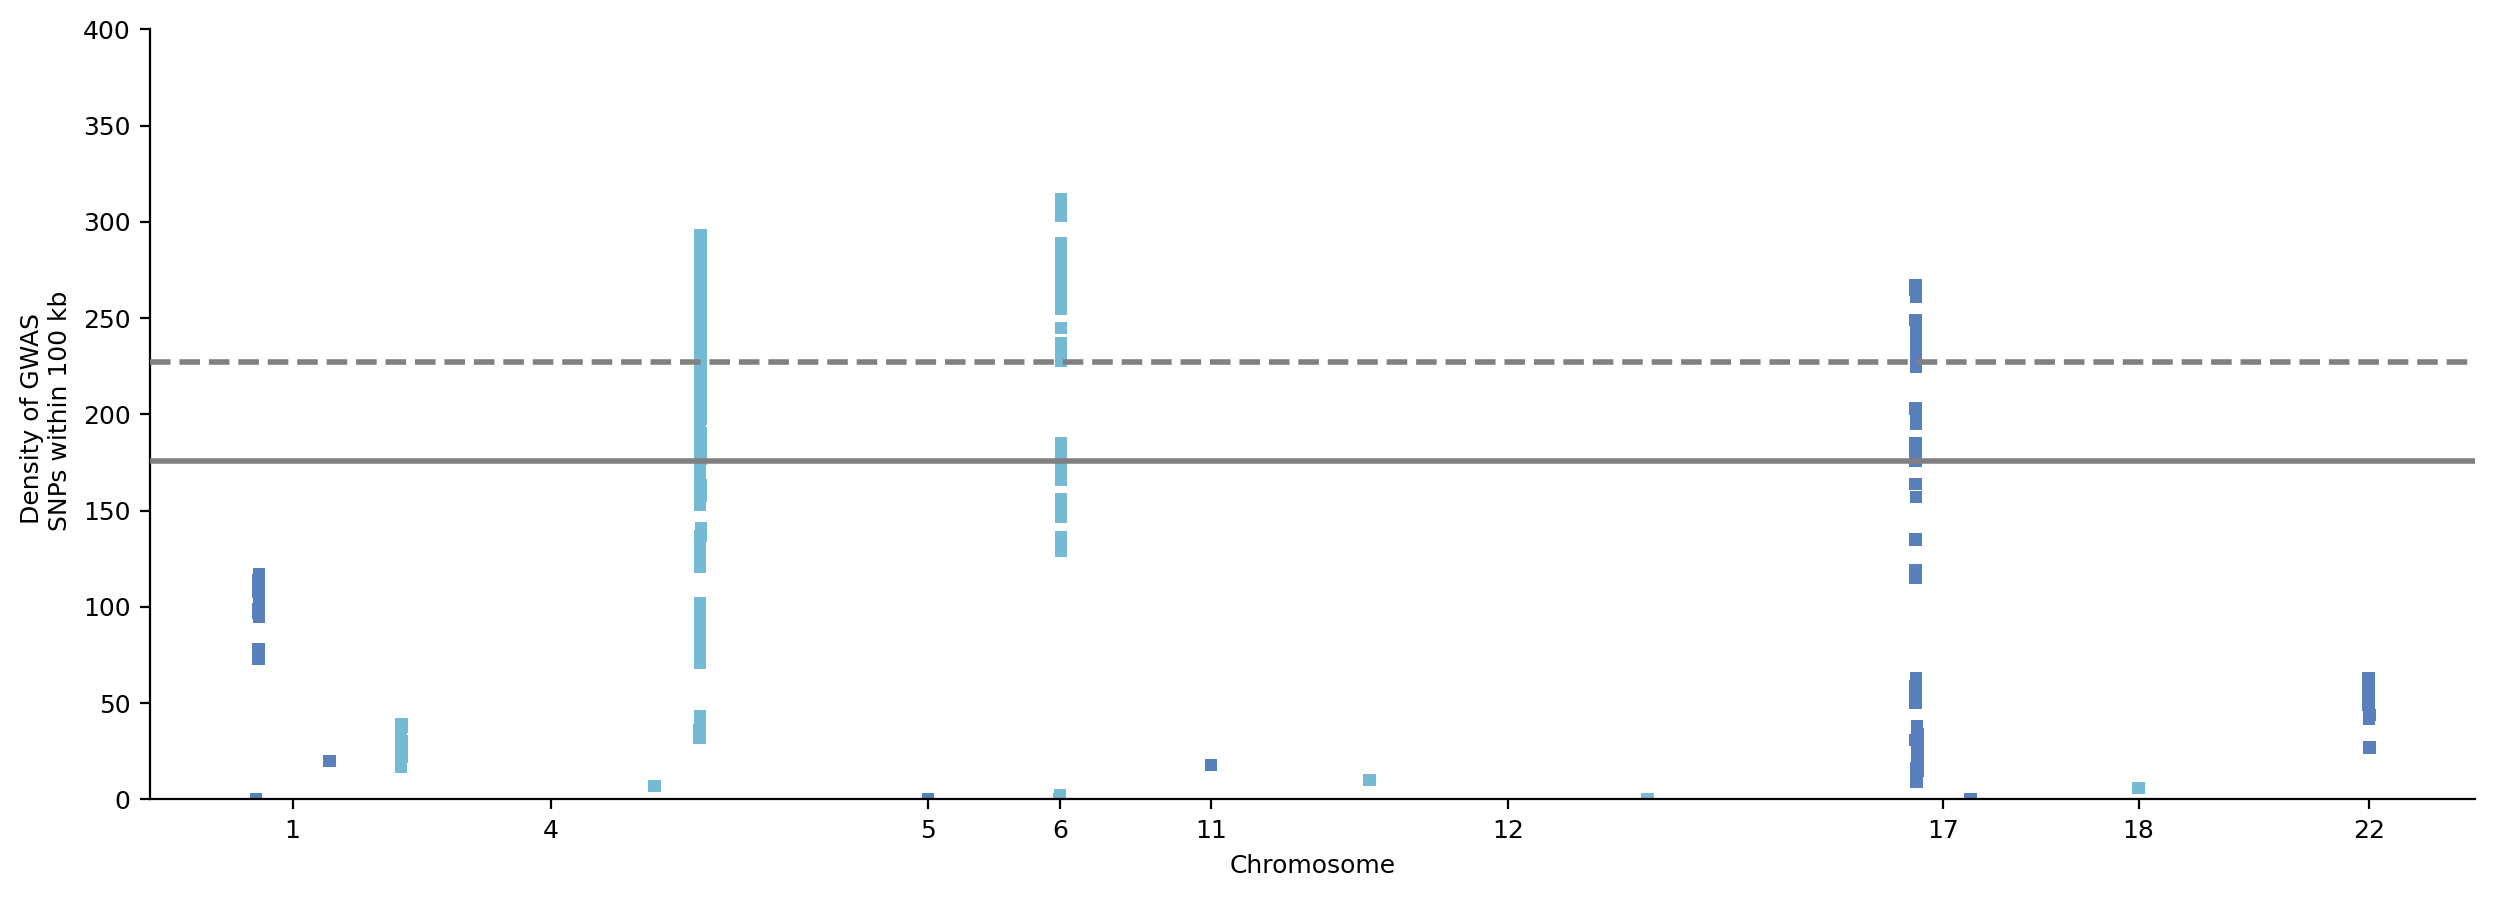

In [5]:
mqqplot(
        gwas_stats.data,
        mode="b",
        snpid='SNPID', 
        chrom='CHR', 
        pos='POS', 
        p='P',
        build = 'hg38'
)